In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
X = pd.read_csv("titanic.csv")
y = X['Survived'].values

In [3]:
X.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1, inplace=True)
X['Embarked'] = X['Embarked'].replace({'C': 0, 'Q': 1, 'S': 2})
X['Sex'] = X['Sex'].replace({'male': 0, 'female': 1})
X['Age'] = X['Age'].fillna(X['Age'].median())
X['Fare'] = X['Fare'].fillna(X['Fare'].median())

# Creating Family Size feature
# SibSp: Sibling/Spouse, Parch: Parent/Child
X['FamilySize'] = X['SibSp'] + X['Parch'] + 1
X.drop(['SibSp', 'Parch'], axis=1, inplace=True)

# Creating IsAlone feature
X['IsAlone'] = (X['FamilySize'] == 1).astype(int)

# Age Binning
X['AgeBin'] = pd.cut(X['Age'], bins=[0, 12, 18, 35, 60, 100], labels=[0, 1, 2, 3, 4])
X.drop(['Age'], axis=1, inplace=True)


X = X.astype(float)

In [4]:
# Normalizing the features
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Outlier removal based on Z-score
X = X[(X.abs() <= 3).all(axis=1)]
y = y[X.index]

In [5]:
correlation_matrix = X.corr()
mat = pd.DataFrame(correlation_matrix['Survived'])
print(mat)

            Survived
Survived    1.000000
Pclass     -0.322181
Sex         0.548378
Fare        0.316552
Embarked   -0.153847
FamilySize  0.109191
IsAlone    -0.229015
AgeBin     -0.120432


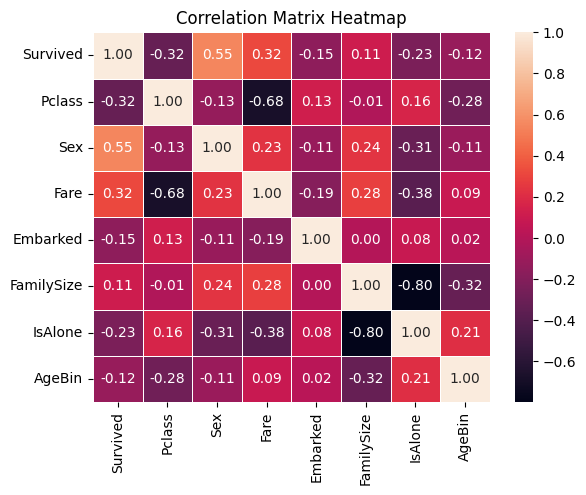

In [6]:
sns.heatmap(correlation_matrix, annot = True, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [7]:
# Adding bias term to X
X = np.hstack((X, np.ones((X.shape[0], 1))))

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def propagate(X, y, weights):
    m = X.shape[0]
    Z = np.dot(X, weights)
    A = sigmoid(Z)
    cost = -np.mean(y * np.log(A) + (1 - y) * np.log(1 - A))
    dW = np.dot(X.T, (A - y.reshape(-1, 1))) / m
    return dW, cost

In [9]:
def optimize(X, y, weights, learning_rate, num_iterations):
    costs = np.zeros(num_iterations)
    for i in range(num_iterations):
        dW, cost = propagate(X, y, weights)
        weights -= learning_rate * dW
        if i % 100 == 0:
            costs[i] = cost
            # print(f"Iteration {i}, Cost: {cost}")
    return weights, costs

In [10]:
def predict(X, weights):
    Z = np.dot(X, weights)
    A = sigmoid(Z)
    return (A > 0.5).astype(int)

In [11]:
#Train Test Split
ratio = 0.8

rows = X.shape[0]
train_size = int(ratio*rows)

X_train = X[0:train_size]
X_test = X[train_size:]

y_train = y[0:train_size]
y_test = y[train_size:]

In [12]:
# Training the model
weights = np.zeros((X.shape[1], 1))
learning_rate = 0.02
num_iterations = 100
weights, costs = optimize(X_train, y_train, weights, learning_rate, num_iterations)

# Predictions and accuracy
predictions = predict(X_test, weights)


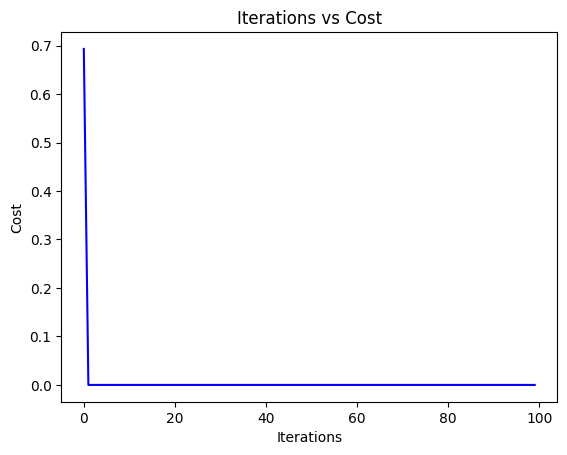

In [13]:
# Plotting the iterations vs cost
plt.plot(range(num_iterations), costs, 'b-')
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Iterations vs Cost")
plt.show()

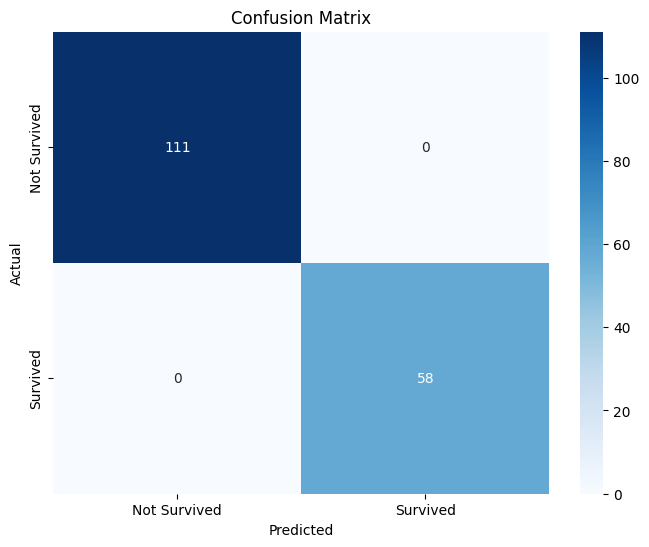

In [14]:
# Confusion Matrix (Manual Calculation)
TP = np.sum((predictions == 1) & (y_test.reshape(-1, 1) == 1))
TN = np.sum((predictions == 0) & (y_test.reshape(-1, 1) == 0))
FP = np.sum((predictions == 1) & (y_test.reshape(-1, 1) == 0))
FN = np.sum((predictions == 0) & (y_test.reshape(-1, 1) == 1))

conf_matrix = np.array([[TN, FP], [FN, TP]])

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [15]:
train_predictions = predict(X_train, weights)
accuracy_train = np.mean(train_predictions == y_train.reshape(-1, 1)) * 100
print(f"Training Accuracy: {accuracy_train}%")

# Calculate accuracy on test set
accuracy_test = np.mean(predictions == y_test.reshape(-1, 1)) * 100
print(f"Test Accuracy: {accuracy_test}%")

precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\nPrecision: {precision}")
print(f"Recall(Sensitivity): {recall}")
print(f"F1 Score: {f1_score}")

Training Accuracy: 99.70370370370371%
Test Accuracy: 100.0%

Precision: 1.0
Recall(Sensitivity): 1.0
F1 Score: 1.0
